In [1]:
# Imports used for writing postgis table
from geoalchemy2.shape import to_shape
import pandas as pd
import json
df = pd.DataFrame()
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
#used for reading postgis table 
import psycopg2  # (if it is postgres/postgis)
from shapely import wkb
#user for working with spatial/data
import pandas as pd
import geopandas as gpd

%matplotlib inline
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
con = psycopg2.connect(database="walkability", user="postgres", password="1234",
    host="172.19.118.205",port="5432")
curs = con.cursor()

In [118]:
sql = "SELECT * FROM compliance.to_all"
sidewalks = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
sql = "select * FROM compliance.centreline_intersection"
centerline_inx = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
# sql = "select * FROM compliance.traffic_signals_to_add"                # signals point file to create crosswalks from
# sql = "select * FROM compliance.traffic_signals"
sql = "select * FROM compliance.pedestrian_crossovers"
# pedex = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')       # shape or geom column  ******
pedex = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='shape')


In [120]:
# potential_crosswalks = sidewalks[sidewalks.geom.length < 25]
# centerlines = centerlines[centerlines.feature__1 !="Local"]
#centerlines_index = centerlines.sindex
line_segs = []
sidewalks_index = sidewalks.sindex
pedex['geom'] = pedex['shape']                              # change for geom *****
for idx,inxpt in pedex.iterrows():
    possible_matches_index = list(sidewalks_index.intersection(inxpt.geom.buffer(25).bounds))
    #using the index of possible matches to filter the centerlines dataframe for only "possible_matches"
    possible_matches = sidewalks.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(inxpt.geom.buffer(25))]
    if not precise_matches.empty:
        #print(precise_matches.gid)
        #precise_matches.plot()
        b= inxpt.geom.buffer(15)
        interpts = precise_matches.unary_union.intersection(b.boundary)
        pts1 = interpts#interpts[(~interpts.is_empty)& (interpts.geom_type == 'Point') ].tolist()
        pts = []
        if pts1.geom_type != "Point":
            for pt in pts1: 
                if pt.geom_type == "Point":
                    pts.append(pt)
                elif pt.geom_type == "MultiPoint":
                    for p in pt: 
                        pts.append(p)
                else: 
                    print("Weird Geom in pts", pt)
        if pts:
            hull  = shapely.geometry.MultiPoint(pts).convex_hull
            if hull.geom_type == "Polygon":
                pts = hull.boundary.coords
                if len(pts) > 1: 
                    for pix in range(0,len(pts),1):
                        pt2 = pts[pix]
                        pt1 = pts[pix-1]
                        line_segs.append(shapely.geometry.LineString([pt1,pt2]))  
            elif hull.geom_type == "LineString":
                line_segs.append(hull)
            elif hull.geom_type == "Point":
                line_segs.append(shapely.geometry.LineString([inxpt.geom,hull]))  
            else: 
                print("Weird Geom in hull",hull)
        else:
            print("no f'n points")
    #         for pix in range(0,len(pts),1):
#             if pix < len(pts):
#                 pt2 = pts[pix]
#                 pt1 = pts[pix-1]
#                 line_segs.append(shapely.geometry.LineString([pt1,pt2]))    
         
                          
                          
                          
                          
                          
                          
                          
                          
                          
#         sql = "SELECT ST_ShortestLine(a.shape,b.geom) FROM compliance.pedestrian_crossovers as a,  compliance.centreline_intersection as b WHERE a.objectid = %s AND b.gid = %s" %(i.objectid,j.gid)
#         curs.execute(sql)
#         res = curs.fetchall()
#         temp_crosswalk = wkb.loads(res[0][0], hex=True)
           

In [122]:
recs = []
for idx,geom in enumerate(line_segs):
    recs.append({"gid":idx,"geometry":geom})
    
out = gpd.GeoDataFrame(recs,geometry='geometry')
out.to_file("/media/DATADRIVE/walkability/test_cross_gen_pc_all.shp")         # rename output ******

In [12]:
con = psycopg2.connect(database="walkability", user="postgres", password="1234",
    host="172.19.118.205",port="5432")
curs = con.cursor()
sql = "SELECT * FROM compliance.pedestrian_crossovers"
res = curs.execute(sql)


In [167]:
hull.boundary.coords[0]

(313669.47066969844, 4841862.981267241)

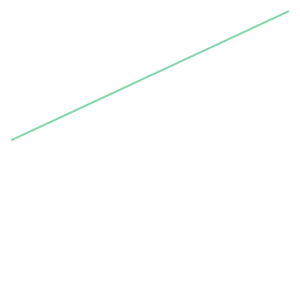

In [45]:
res[0][0]

'0102000020E307000002000000102DB29DED0D13413208AC54C37152418FC2F5A8BD791241022B87BE746D5241'

In [107]:
import arcpy


ModuleNotFoundError: No module named 'arcpy'

In [3]:
# find closest point on line                                ********************************

sql = "SELECT * FROM compliance.to_all"
sidewalks = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
sql = "select * FROM compliance.centreline_filtered"
centerline_fil = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')
# sql = "select * FROM compliance.pedestrian_crossovers"
sql = "select * FROM compliance.crosswalks_to_add_on_ped_crosswalks"
pedex = gpd.GeoDataFrame.from_postgis(sql, con, geom_col='geom')

In [10]:
# draw crosswalk

con = psycopg2.connect(database="walkability", user="postgres", password="1234",
    host="172.19.118.205",port="5432")
curs = con.cursor()
results = []
for idx,i in pedex.iterrows():
   for jdx,j in sidewalks.iterrows():
     sql = "select st_distance(st_closestpoint(l.geom, p.geom), p.geom) as shortest_distance, ST_AsText(ST_ClosestPoint(l.geom,p.geom)) As pt1, ST_AsText(ST_ClosestPoint(p.geom,l.geom)) As pt2, p.objectid from compliance.crosswalks_to_add_on_ped_crosswalks p, compliance.to_all l where p.objectid=%s and  order by shortest_distance asc limit 2;" %(i.objectid,j.gid)
     curs.execute(sql)
     res = curs.fetchall()
     temp_crosswalk = wkb.loads(res[0][0], hex=True)
     row_count = 0
     for row in res:
        row_count += 1
        print("row: %s    %s\n" % (row_count, row))
        break
     break


TypeError: not all arguments converted during string formatting

In [11]:
# draw crosswalk

con = psycopg2.connect(database="walkability", user="postgres", password="1234",
    host="172.19.118.205",port="5432")
curs = con.cursor()
results = []
for idx,i in pedex.iterrows():
   for jdx,j in sidewalks.iterrows():
     sql = "select st_distance(st_closestpoint(l.geom, p.geom), p.geom) as shortest_distance, ST_AsText(ST_ClosestPoint(l.geom,p.geom)) As pt1, ST_AsText(ST_ClosestPoint(p.geom,l.geom)) As pt2, p.objectid from compliance.crosswalks_to_add_on_ped_crosswalks p, compliance.to_all l where p.objectid=%s and  order by shortest_distance asc limit 2;" %(i.objectid,j.gid)
     curs.execute(sql)
     res = curs.fetchall()
     temp_crosswalk = wkb.loads(res[0][0], hex=True)
     row_count = 0
     for row in res:
        row_count += 1
        print("row: %s    %s\n" % (row_count, row))
        break
     break

TypeError: not all arguments converted during string formatting